In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

In [80]:
df=sns.load_dataset('titanic')

In [81]:
df.head(2)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False


In [82]:
df=df.drop(['embark_town','who'],axis=1)

In [83]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
sibsp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292
embarked,889,3,S,644,NaN,NaN,NaN,NaN,NaN,NaN,NaN
class,891,3,Third,491,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adult_male,891,2,True,537,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
def find_missing_values(df):
    percentage_missing=pd.Series(round((df.isnull().sum()/df.shape[0])*100,2),name='percentage of missing lines')
    total_missing=pd.Series(df.isnull().sum(),name='Total Missing Lines')
    missing_values=pd.concat([total_missing,percentage_missing],axis=1)
    missing_values.rename({0:'Total Missing Data Points',1:'Percentage of Missing Data points'},inplace=True)
    return missing_values[missing_values['Total Missing Lines'] !=0]

In [85]:
find_missing_values(df)

,Total Missing Lines,percentage of missing lines
age,177,19.87
embarked,2,0.22
deck,688,77.22


In [86]:
df.drop('deck',axis=1,inplace=True)

In [87]:
df['age'].fillna(np.mean(df['age']),inplace=True)

In [88]:
find_missing_values(df)

,Total Missing Lines,percentage of missing lines
embarked,2,0.22


In [89]:
def find_outlier_z_score(features,df):
    summary_outliers_df=pd.DataFrame()
    summary_outliers_data = {'Feature_Name':[],'Count_Outliers':[],'Percentage_Outliers':[]}
    feature_outliers_df = pd.DataFrame()
    for feature in features:
        z_scores = st.zscore(df[feature])
        threshold = 3
        outliers_mask = (np.absolute(z_scores)>threshold)
        outliers_indices = np.column_stack(np.where(outliers_mask))
        feature_outliers_df = df.iloc[outliers_indices[:, 0]]
        summary_outliers_data['Feature_Name'].append(feature)
        summary_outliers_data['Count_Outliers'].append(feature_outliers_df.shape[0])
        summary_outliers_data['Percentage_Outliers'].append(np.round((feature_outliers_df.shape[0]/df[feature].shape[0])*100,2))
        summary_outliers_df=pd.DataFrame(summary_outliers_data)
        summary_outliers_df
    summary_outliers_df=summary_outliers_df[summary_outliers_df['Count_Outliers'] !=0]
    summary_outliers_df.sort_values(by='Count_Outliers',ascending=False,inplace=True)
    return summary_outliers_df
def remove_outlier(feature,df):
    z_scores = st.zscore(df[feature])
    threshold = 3
    outliers_mask = (np.absolute(z_scores)>threshold)
    outliers_indices = np.column_stack(np.where(outliers_mask))
    feature_outliers_df = df.iloc[outliers_indices[:, 0]]
    return df[~df[feature].isin(feature_outliers_df[feature])]

In [90]:
numeric_df=df[['age','fare']]


In [91]:
y_target

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: survived, Length: 891, dtype: int64

In [92]:
cat_df

,pclass,sex,sibsp,parch,embarked,class,adult_male,alone
0,3,male,1,0,S,Third,True,False
1,1,female,1,0,C,First,False,False
2,3,female,0,0,S,Third,False,True
3,1,female,1,0,S,First,False,False
4,3,male,0,0,S,Third,True,True
...,...,...,...,...,...,...,...,...
886,2,male,0,0,S,Second,True,True
887,1,female,0,0,S,First,False,True
888,3,female,1,2,S,Third,False,False
889,1,male,0,0,C,First,True,True


In [93]:
features = numeric_df.columns.to_list()[1:]
summary_outliers_df=find_outlier_z_score(features,df=numeric_df.iloc[:,1:])

In [94]:
summary_outliers_df

,Feature_Name,Count_Outliers,Percentage_Outliers
0,fare,20,2.24


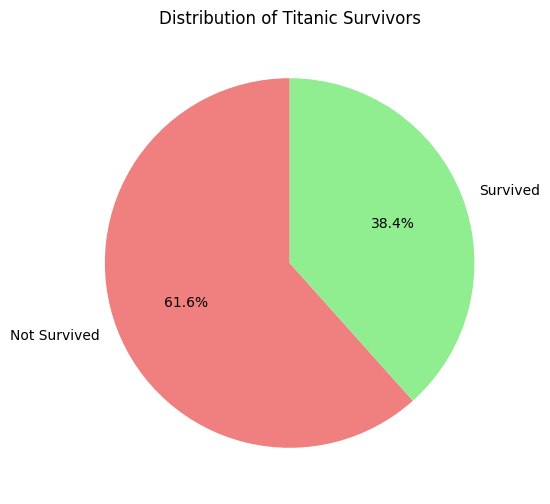

In [95]:
survived_counts = df['survived'].value_counts()

labels = ['Not Survived', 'Survived']
colors = ['lightcoral', 'lightgreen']

plt.figure(figsize=(6, 6))
plt.pie(survived_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

plt.title('Distribution of Titanic Survivors')
plt.show()

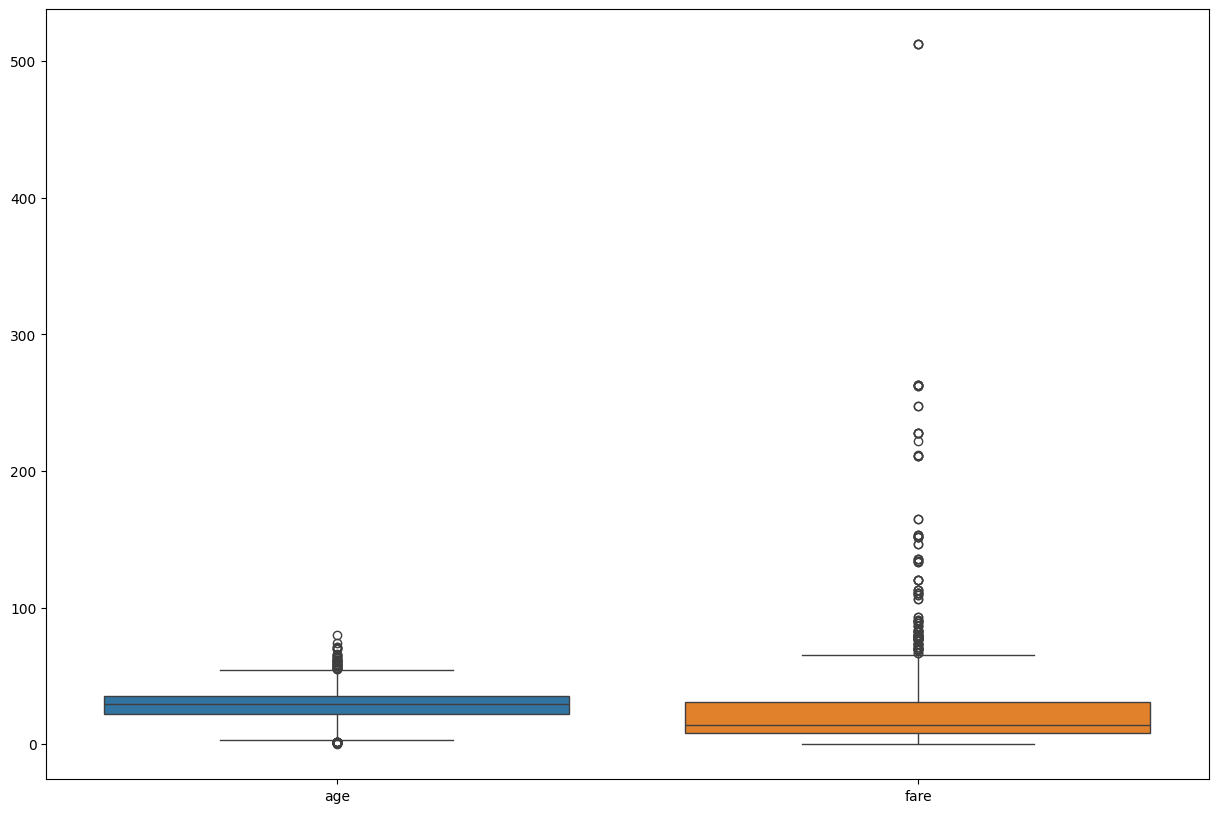

In [96]:
plt.figure(figsize=(15,10))
sns.boxplot(numeric_df)
plt.show()

#### Categorical Encoding
- Ordinal encoding: 'pclass', 'embarked', 'class'
- Dummies: 'sex', 'sibsp', 'parch', 'who', 'adult_male', 'alone'

#### Model Building

In [100]:
columns = ['Model Name', 'CM','Accuracy','precision', 'recall', 'f1']
model_summary_stats = pd.DataFrame(columns=columns)
def UpdateSummaryTable(model_name,cm,acc,precision,recall,f1):
    global model_summary_stats
    new_row = pd.DataFrame([[model_name,cm,acc,precision,recall,f1]],columns=columns)
    model_summary_stats=pd.concat([model_summary_stats,new_row])
    return model_summary_stats

In [132]:
X=df_scaled_encoded
X_train,X_test,y_train,y_test = train_test_split(X,y_target)
print("X-train:",X_train.shape)
print("y-train:",y_train.shape)
print("X-test:",X_test.shape)
print("y-test:",y_test.shape)

X-train: (668, 11)
y-train: (668,)
X-test: (223, 11)
y-test: (223,)


In [133]:
from sklearn.tree import DecisionTreeClassifier,plot_tree

full_classifier=DecisionTreeClassifier(criterion='entropy',max_depth=5)

In [135]:
full_classifier.fit(X_train,y_train)

ValueError: could not convert string to float: 'male'

In [107]:
full_y_predict=full_classifier.predict(X_test)

In [108]:
full_cm=confusion_matrix(y_test,full_y_predict)
full_accuracy = accuracy_score (y_test,full_y_predict)
full_precision = precision_score(y_test,full_y_predict)
full_recall = recall_score(y_test,full_y_predict)
full_f1_score = f1_score(y_test,full_y_predict)

In [109]:
UpdateSummaryTable("Full features decision tree model",full_cm,full_accuracy,full_precision,full_recall,full_f1_score)

C:\Users\gvinaykumar\AppData\Local\Temp\ipykernel_34776\3459304721.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_summary_stats=pd.concat([model_summary_stats,new_row])


,Model Name,CM,Accuracy,precision,recall,f1
0,Full features decision tree model,"[[124, 13], [25, 61]]",0.829596,0.824324,0.709302,0.7625


In [110]:
print(classification_report(y_test,full_y_predict))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       137
           1       0.82      0.71      0.76        86

    accuracy                           0.83       223
   macro avg       0.83      0.81      0.81       223
weighted avg       0.83      0.83      0.83       223



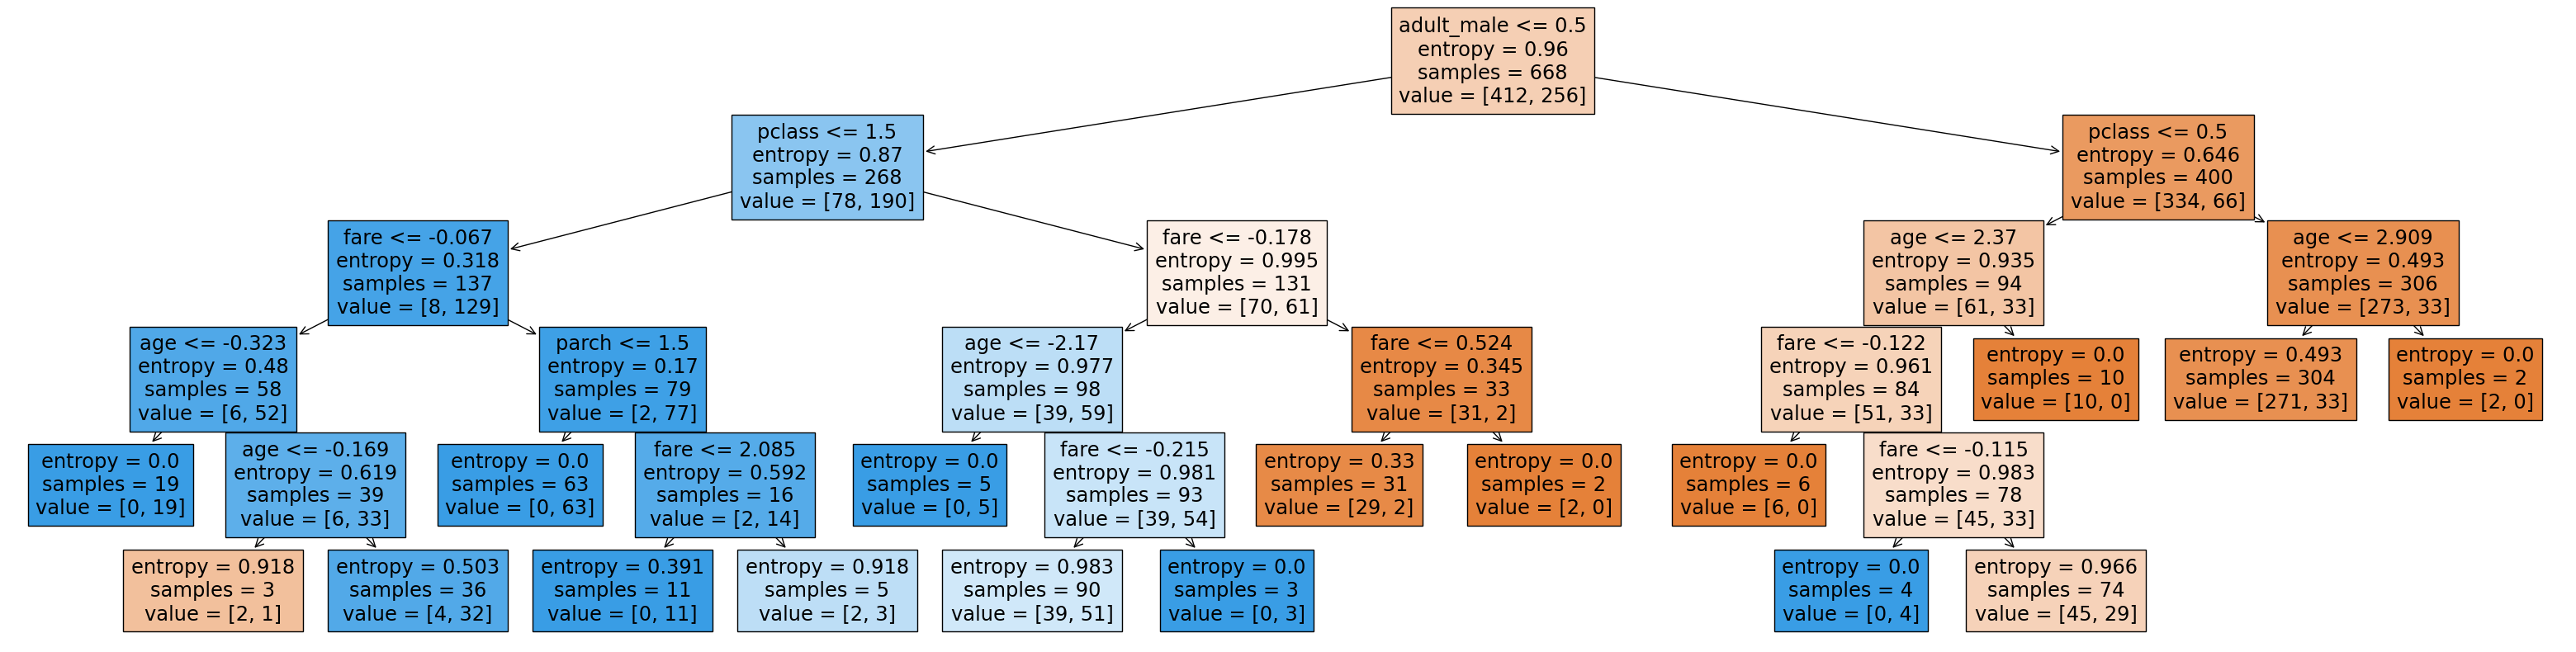

In [111]:
plt.figure(figsize=(40,10))
plot_tree(full_classifier,feature_names=X_train.columns,filled=True)
plt.show()

In [112]:
feature_importance = pd.DataFrame({'features':X_train.columns,"Importance":full_classifier.feature_importances_})
feature_importance.sort_values(by='Importance')

,features,Importance
2,sibsp,0.000000
5,alone,0.000000
6,sex_female,0.000000
7,sex_male,0.000000
9,embarked,0.000000
10,class,0.000000
3,parch,0.013685
0,age,0.067211
1,fare,0.134324
8,pclass,0.270778


### Dropping least importance features

In [113]:
less_importance_features=feature_importance.loc[feature_importance['Importance']==0]['features'].to_list()

In [114]:
less_importance_features

['sibsp', 'alone', 'sex_female', 'sex_male', 'embarked', 'class']

In [115]:
df_importance_features=df_scaled_encoded.drop(less_importance_features,axis=1)

In [116]:
X=df_importance_features
X_train_imp,X_test_imp,y_train_imp,y_test_imp = train_test_split(X,y_target)
print("X-train:",X_train_imp.shape)
print("y-train:",y_train_imp.shape)
print("X-test:",X_test_imp.shape)
print("y-test:",y_test_imp.shape)

X-train: (668, 5)
y-train: (668,)
X-test: (223, 5)
y-test: (223,)


In [117]:
classifier_imp=DecisionTreeClassifier(criterion='entropy',max_depth=5)
classifier_imp.fit(X_train_imp,y_train_imp)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

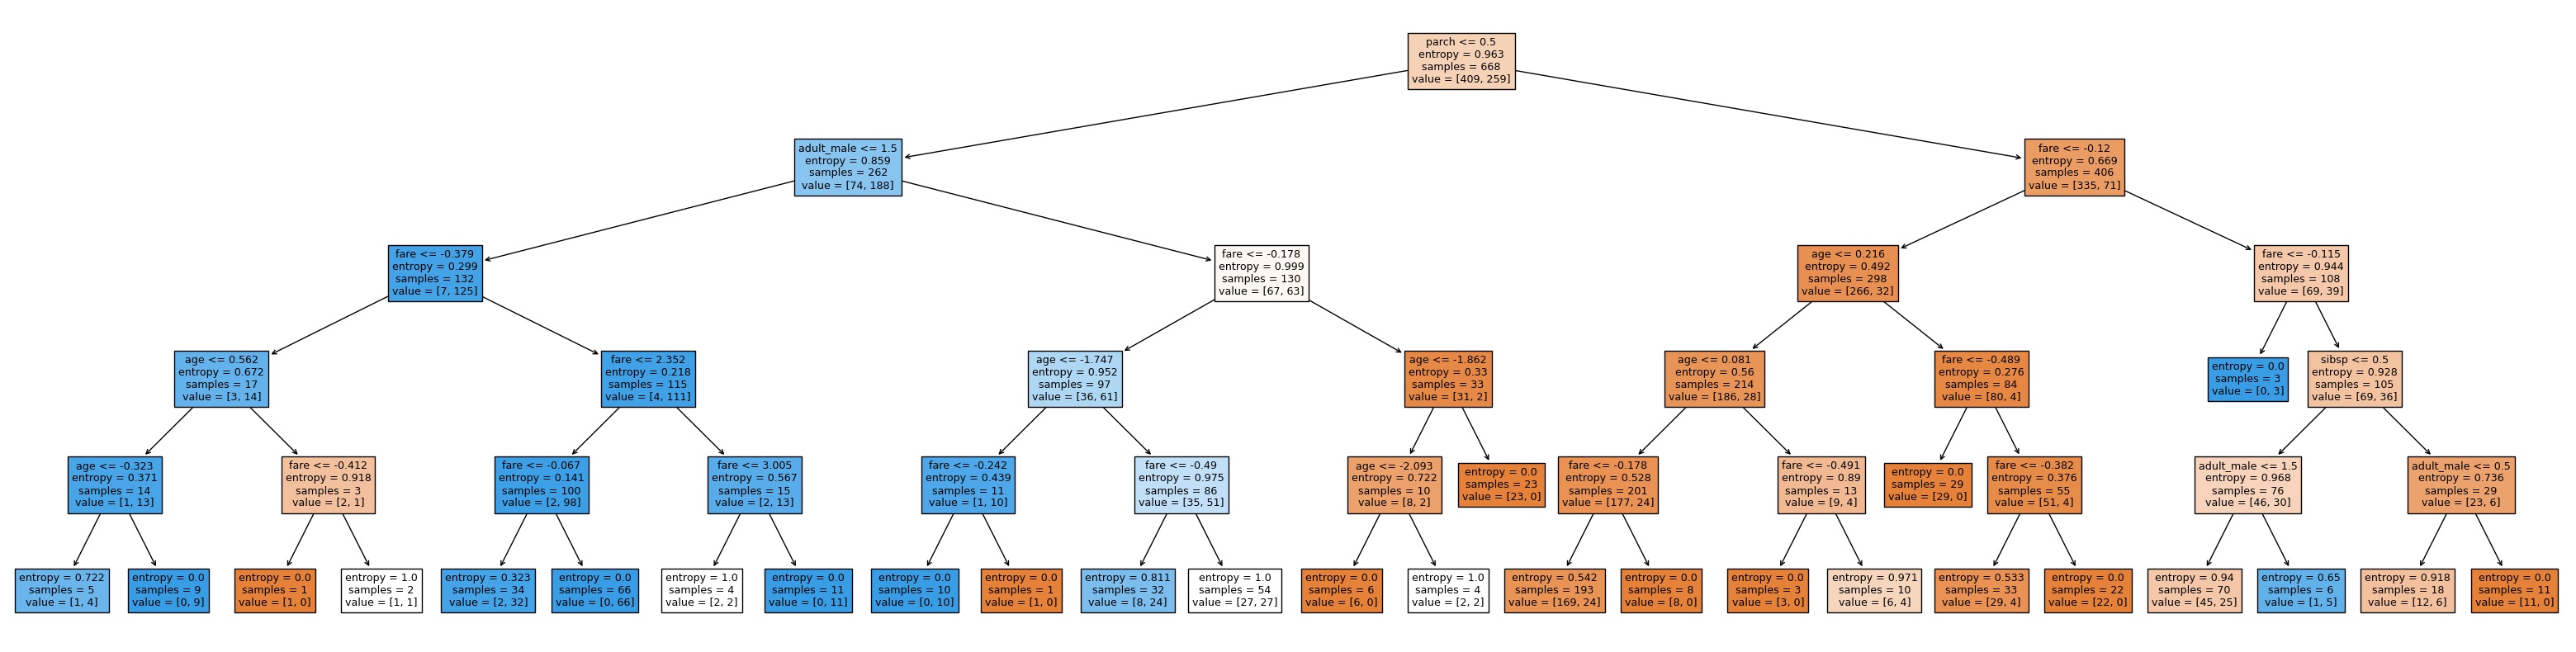

In [118]:
plt.figure(figsize=(40,10))
plot_tree(classifier_imp,feature_names=X_train.columns,filled=True)
plt.show()

In [119]:
y_pred_sign=classifier_imp.predict(X_test_imp)

In [120]:
sign_cm=confusion_matrix(y_test_imp,y_pred_sign)
sign_accuracy = accuracy_score (y_test_imp,y_pred_sign)
sign_precision = precision_score(y_test_imp,y_pred_sign)
sign_recall = recall_score(y_test_imp,y_pred_sign)
sign_f1_score = f1_score(y_test_imp,y_pred_sign)

In [121]:
UpdateSummaryTable("Importance features decision tree model",sign_cm,sign_accuracy,sign_precision,sign_recall,sign_f1_score)

,Model Name,CM,Accuracy,precision,recall,f1
0,Full features decision tree model,"[[124, 13], [25, 61]]",0.829596,0.824324,0.709302,0.762500
0,Importance features decision tree model,"[[131, 9], [32, 51]]",0.816143,0.850000,0.614458,0.713287


In [122]:
from sklearn.model_selection import GridSearchCV
#Assigning parameters
param_grid = {
    "max_depth":np.arange(2,10,1),
"min_samples_split":[2,5,7,10],
"min_samples_leaf":[1,2,4],
"criterion":['entropy','gini'],
"max_features":['sqrt','log2',None]
}

para_calssifier = DecisionTreeClassifier()

In [123]:
grid_cv=GridSearchCV(estimator=para_calssifier,param_grid=param_grid,cv=5,scoring='accuracy')

In [124]:
grid_cv.fit(X_train_imp,y_train_imp)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 7, 10]},
             scoring='accuracy')

In [125]:
grid_cv.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [126]:
grid_cv.best_score_

0.8292559757602962

In [127]:
grid_cv.best_estimator_

DecisionTreeClassifier(max_depth=4)

In [128]:
y_pred_hyper=grid_cv.best_estimator_.predict(X_test_imp)

In [129]:
hyper_cm=confusion_matrix(y_test_imp,y_pred_hyper)
hyper_accuracy = accuracy_score (y_test_imp,y_pred_hyper)
hyper_precision = precision_score(y_test_imp,y_pred_hyper)
hyper_recall = recall_score(y_test_imp,y_pred_hyper)
hyper_f1_score = f1_score(y_test_imp,y_pred_hyper)

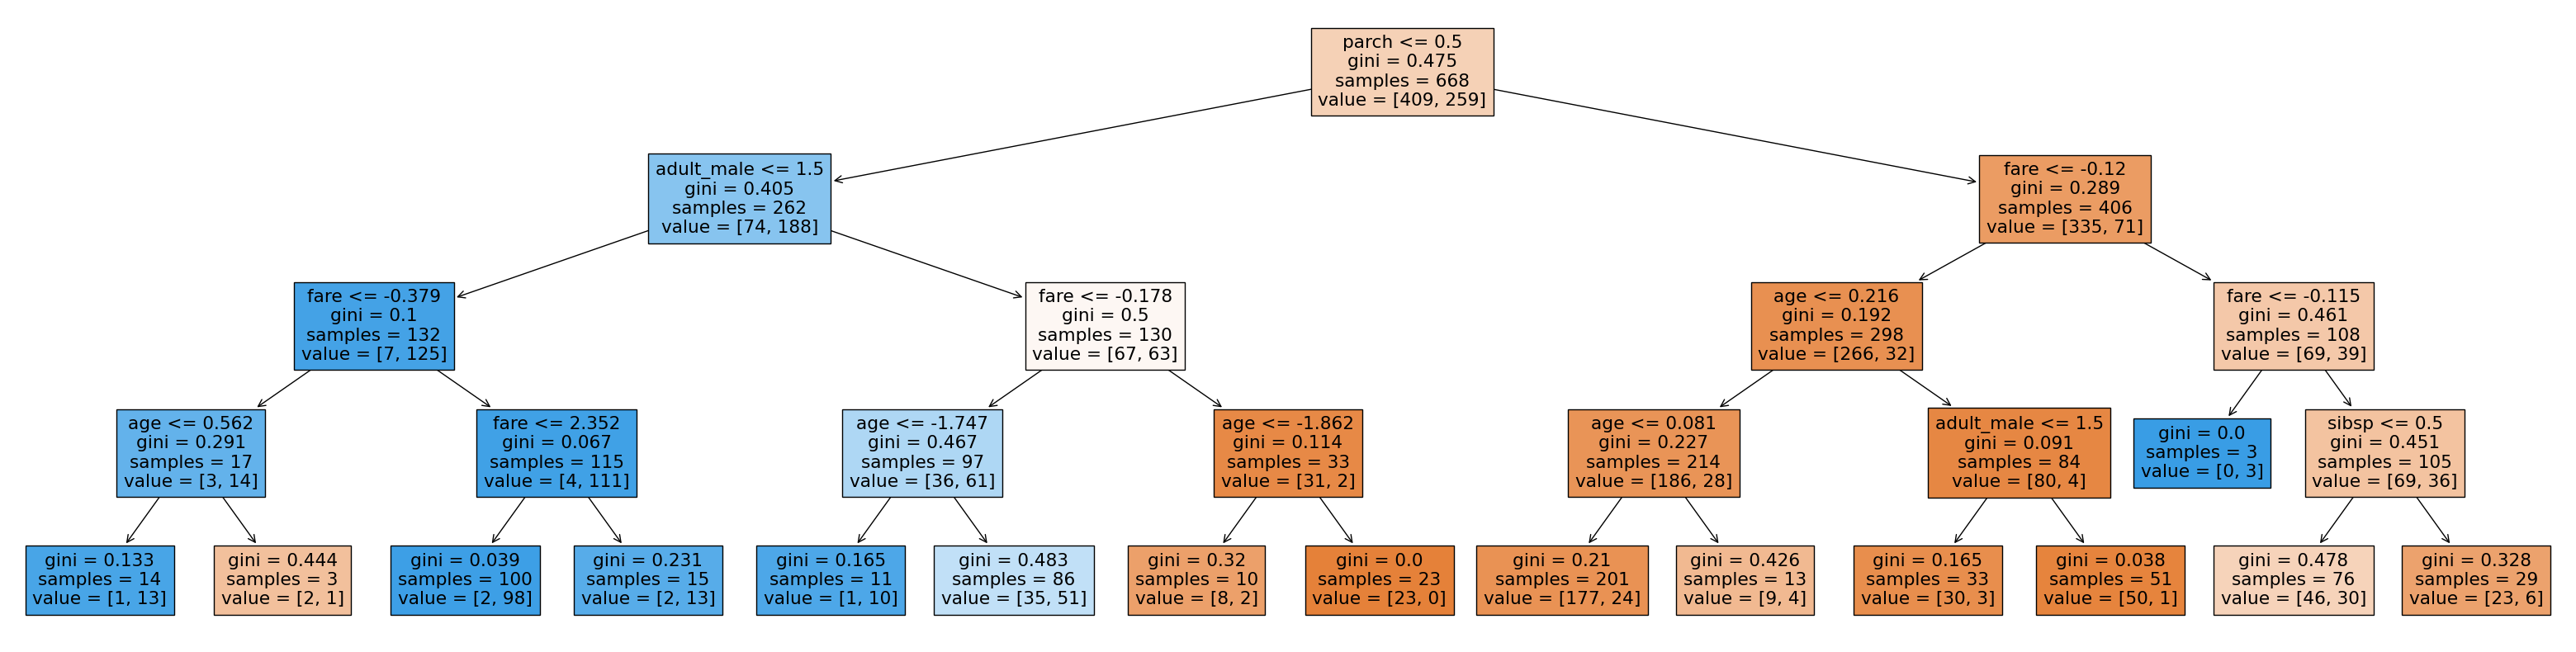

In [131]:
plt.figure(figsize=(40,10))
plot_tree(grid_cv.best_estimator_,feature_names=X_train.columns,filled=True)
plt.show()

In [130]:
UpdateSummaryTable("decision tree model after hyperparametertuning",hyper_cm,hyper_accuracy,hyper_precision,hyper_recall,hyper_f1_score)

,Model Name,CM,Accuracy,precision,recall,f1
0,Full features decision tree model,"[[124, 13], [25, 61]]",0.829596,0.824324,0.709302,0.762500
0,Importance features decision tree model,"[[131, 9], [32, 51]]",0.816143,0.850000,0.614458,0.713287
0,decision tree model after hyperparametertuning,"[[123, 17], [21, 62]]",0.829596,0.784810,0.746988,0.765432
